Asillab Task 03/04/2023 ------
Furkan Yüceyalçın

#Environment Setup

In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, Dropout, add

import albumentations as A
from functools import partial

In [2]:
print(tf.__version__)

2.12.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive')

Mounted at /content/drive


In [4]:
# !pip install unrar

In [5]:
# !unrar x '/content/drive/MyDrive/furkan (1-2).rar'  # Unrared to folder furkan (1-2)
# !unrar x '/content/drive/MyDrive/furkan (3-6).rar'  # Unrared to folder furkan_(3to6)
# !unrar x '/content/drive/MyDrive/furkan (7-14).rar' # Unrared to folder furkan_7-14

#Visualizing and exploring the data

In [6]:
folder_name = 'furkan_(3to6)'
img_names = sorted(os.listdir(os.path.join(os.getcwd(), folder_name, 'Images')))
label_names = sorted(os.listdir(os.path.join(os.getcwd(), folder_name, 'Labels')))

In [7]:
# looking at random sample to check if images and labels match
print(img_names[25], label_names[25], sep='\n') 

B-19899-16-1-A-4.vsi - 20x (12, x=0, y=48330, w=36311, h=15077).png
B-19899-16-1-A-4.vsi - 20x (12, x=0, y=48330, w=36311, h=15077)-label.png


In [8]:
# this functinon does not care about artifact or tumor
def plot_segmentation_images(image_names, image_label_names, Random=True):
  w = 256
  h = 128
  figure = plt.subplots(figsize=(10, 10))
  for i in range(18):
    random_number = np.random.randint(len(image_names)) if Random else i
    img = cv2.imread(os.path.join(os.getcwd(), 'furkan_(3to6)', 'Images',image_names[random_number]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (w, h))
    img_label = cv2.imread(os.path.join(os.getcwd(), 'furkan_(3to6)', 'Labels', image_label_names[random_number]))
    img_label = cv2.resize(img_label, (w, h))
    img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2GRAY)

    mask = np.ma.masked_where(img_label>0, img_label)
    img_label_mask = np.ma.masked_array(img_label, mask)

    plt.subplot(6, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.imshow(img_label_mask, cmap='jet', alpha=0.4)
    plt.tight_layout()
    plt.axis('off')
  plt.show()

<ipython-input-8-5fc76fbb5efc>:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6, 3, i+1)


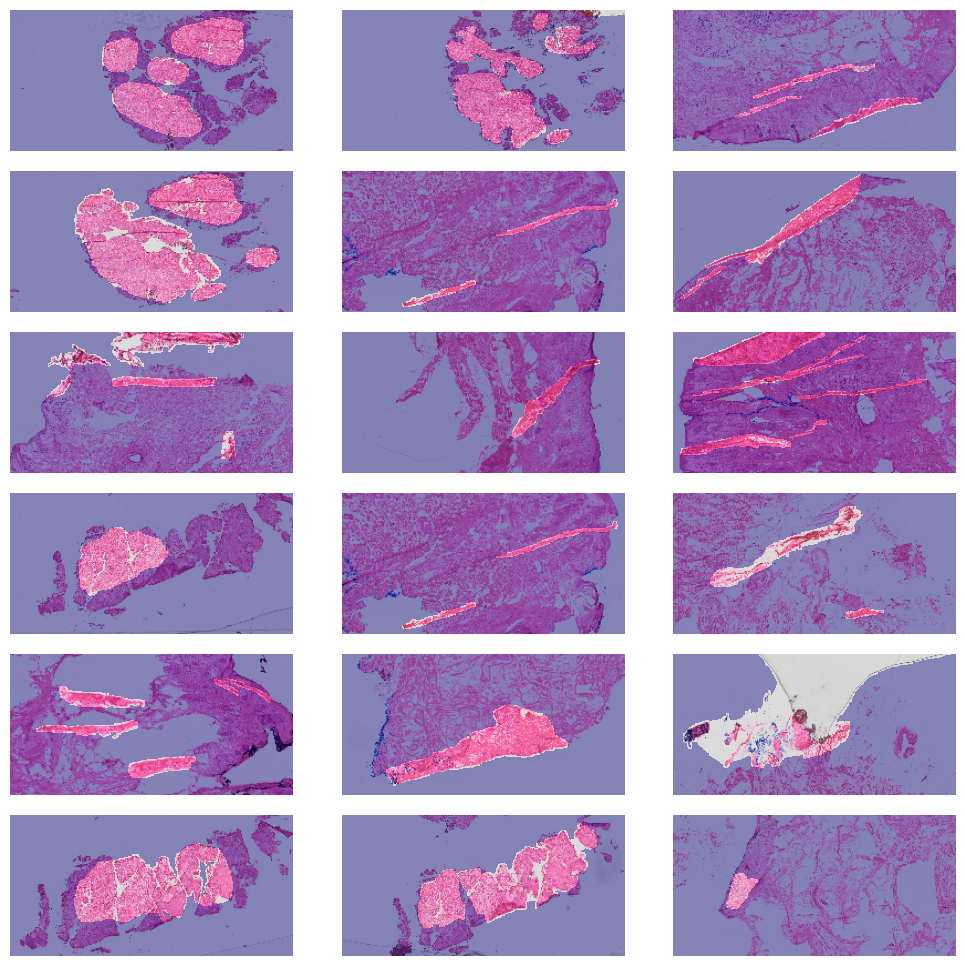

In [9]:
# Plots random segmentation sample
plot_segmentation_images(img_names, label_names)

# Loading and Preparing the data

I have 3 different folders to work with, first I will combine them into dataset, then split them into training, val and test. For that I build get_dataset_from_folder_list() function that takes folder list that includes folder names (the folders must be subfolders of os.getcwd()) and returns a dataset that returns paths of image and its corresponding labels.


In [10]:
IMG_SIZE = 512
IMG_CHANNELS = 3
batch_size = 4
buffer_size = 1000
seed = 42
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
def get_dataset_from_folder_list(folder_list):
  # Get a list that contains folders that are extracted from rar.
  # Returns paths of images and labels
  image_paths = []
  label_paths = []
  for folder in folder_list:
    image_dir = os.path.join(os.getcwd(), folder, 'Images')
    label_dir = os.path.join(os.getcwd(), folder, 'Labels')
    for file in glob(os.path.join(image_dir, '*.png')):
      image_paths.append(file)
    for file in glob(os.path.join(label_dir, '*.png')):
      label_paths.append(file)
  image_paths.sort()
  label_paths.sort()
  ds = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
  return ds

This function returns a function that creates a dataset corresponding to a specific label type. The function takes inputs of image path and label paths and reads them using TensorFlow I/O methods. **The task asks us to train the model separately for artifacts and tumors**, this function uses color channels to determine the type of label that is required. Green for artifact and red for tumors.

The load_labeltype_image() function reads from the dataset that have paths elements, normalizes the image and labels. For labels, seperates the color channels to get the desired label_type then converts it to grayscale (1 channel) image.

In [12]:
def load_image_function(label_type='artifact'):
  def load_image(image_path, label_path, size=(512, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size)

    label_raw = tf.io.read_file(label_path)
    label_raw = tf.image.decode_png(label_raw, channels=3)
    label_raw = tf.image.resize(label_raw, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    if label_type == 'artifact':
      label = label_raw[:,:,1] # Artifacts are labeled green
    elif label_type =='tumor':
      label = label_raw[:,:,0] # Tumors are labeled red
    elif label_type == None:
      label = label_raw
      label = tf.image.rgb_to_grayscale(label)
    else:
      raise ValueError(f"Failed to decode label image from '{label_type}'. Please enter valid label_type")

    label = tf.where(label == 0, 0, 1)
    label = tf.image.convert_image_dtype(label, tf.int32)
     # Add an extra dimension to label tensor to return (h, w, channels)
    label = tf.expand_dims(label, axis=-1)
    return image, label

  return load_image


In [13]:
load_artifact_image = load_image_function(label_type='artifact')

To remove blank images from our tf.data.Dataset, we need a filter function that returns False for labels containing only 0 pixels. Will use it with tf.data.Dataset.filter() method to ensure that only valid labels are included in the dataset.

In [14]:
def filter_zero_labels(image, label):
  if tf.reduce_sum(label) == 0:
    return False
  else:
    return True

In [15]:
folder_list = ['furkan (1-2)', 'furkan_(3to6)', 'furkan_7-14']

dataset = (
    get_dataset_from_folder_list(folder_list)
    .map(load_artifact_image)
    .filter(filter_zero_labels)
    .shuffle(buffer_size=buffer_size)
)

# I will batch the datasets after splitting into train, val and test since
# dataset is very small and this may cause inequality in distributing
# the data if I use it after batching.

After using the Dataset.filter() method, some methods cannot be used due to limitations in TensorFlow. For example, the tf.experimental.cardinality() method returns -2 after using the Dataset.filter() method. len(dataset) won't work as well. Best solution is to get the length before filterin but I decided to go like this. This method is significantly longer, it took 30 seconds but i couldn't find another way after filtering.

In [16]:
# len(dataset) does not work after Dataset.filter method.
dataset_size = dataset.reduce(0, lambda x,_: x+1).numpy()

In [17]:
# Spliting the data 80% train, 10% val, 10% test
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

In [18]:
train_dataset_size = train_dataset.reduce(0, lambda x,_: x+1).numpy()
val_dataset_size = val_dataset.reduce(0, lambda x,_: x+1).numpy()
test_dataset_size = test_dataset.reduce(0, lambda x,_: x+1).numpy()

In [19]:
# Sanity check
print(f"Train, validation and test dataset batch count: {train_dataset_size + val_dataset_size + test_dataset_size}")
print(f"Base dataset batch count: {dataset_size}")

Train, validation and test dataset batch count: 131
Base dataset batch count: 131


In [20]:
steps_per_epoch = int(train_dataset_size // batch_size)
val_steps = int(val_dataset_size // batch_size)
print(f"Batch Size: {batch_size}\nSteps_per_epoch: {steps_per_epoch}\nValidation_steps: {val_steps}")

Batch Size: 4
Steps_per_epoch: 26
Validation_steps: 3


The first function, named augment, performs data augmentation on an input image and mask using the Albumentations library. Augmentations are mostly spatial because  by simulating variations in image orientation, scaling, and shearing, accounting for variability in medical imaging data. Additionally, they can help the model to handle complex shapes by introducing local deformations, and can increase the size of the training dataset.

The second function is there for tf.numpy_function(), this function returns the augmented image and mask. The function also sets the shape of the augmented image and mask, since the tf.numpy_function() call can cause the shape of the output tensors to be lost.

In [21]:
def augment(image, mask, size=(512, 512)):
  transforms = A.Compose([
      A.OneOf([
          A.Transpose(),
          A.VerticalFlip(),
          A.HorizontalFlip(),
          A.RandomRotate90(),
          A.NoOp()], p=1.0),

      A.ShiftScaleRotate(p=0.9),
      A.GridDistortion(p=0.5),
      A.ElasticTransform(p=0.5),

      A.OneOf([
          A.RandomBrightnessContrast(p=0.4),    
          A.RandomGamma(p=0.4)], p=0.75)
      
    ], additional_targets={'mask': 'mask'})

  data = {"image":image, "mask":mask}
  aug_data = transforms(**data)

  aug_img = aug_data["image"]
  aug_img = tf.cast(aug_img, tf.float32)

  aug_mask = aug_data["mask"]
  # Making sure labels are binary (background or label)
  aug_mask = np.where(aug_mask == 0, 0, 1)
  aug_mask = tf.cast(aug_mask, tf.int32)

  return aug_img, aug_mask

# I got "Tensor has no attribute .numpy() method" error. To fix this I used tf.numpy_function()
def process_data(image, mask, h=512, w=512):
  image, mask = tf.numpy_function(func=augment, inp=[image, mask], Tout=(tf.float32, tf.int32))
  # The datasets loses its shape after applying a tf.numpy_function, so this is 
  # necessary for the sequential model and when inheriting from the model class.
  image.set_shape((h, w, 3))
  mask.set_shape((h, w, 1))
  return image, mask


In [22]:
# ///// Pipelining /////

# Only appllying augmentation on train dataset
train_dataset = (
    train_dataset
    .cache()
    .map(partial(process_data))
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

val_dataset = (
    val_dataset
    .cache()
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

test_dataset = test_dataset.batch(batch_size)

In [23]:
train_dataset.element_spec

(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))

<ipython-input-31-f8762963fb40>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(batch_size, 2, i+1)


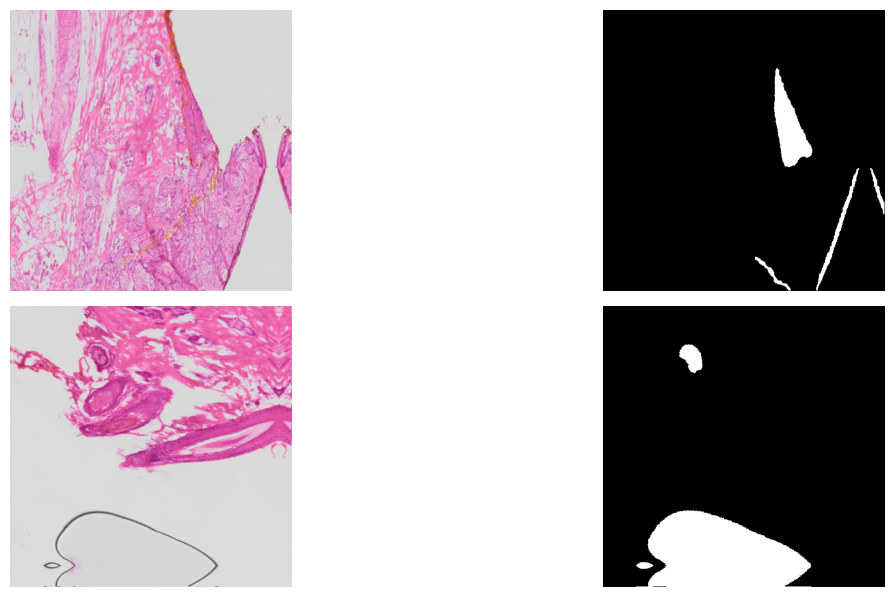

In [31]:
# Looking at the first batch
for image, label in train_dataset.take(1):
  plt.subplots(figsize=(12, 12))
  for i in range(0, batch_size, 2):
    plt.subplot(batch_size, 2, i+1)
    plt.imshow(image[i])
    plt.axis('off')
    plt.subplot(batch_size, 2, i+2)
    plt.imshow(label[i], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [25]:
for image_batch, labels_batch in train_dataset.take(1):
  print('\tTraining:')
  print('Max image pixel value: ',tf.math.reduce_max(image_batch).numpy())
  print('Min image pixel value: ',tf.math.reduce_min(image_batch).numpy())
  print('Unique label pixel value: ', np.unique(labels_batch[0].numpy()))
  print(f'Image batch shape:  {image_batch.shape}')
  print(f'Label batch shape: {labels_batch.shape}')
  break

for image_batch, labels_batch in val_dataset.take(1):
  print('\n\tValidation:')
  print('Max image pixel value: ',tf.math.reduce_max(image_batch).numpy())
  print('Min image pixel value: ',tf.math.reduce_min(image_batch).numpy())
  print('Unique label pixel value: ', np.unique(labels_batch[0].numpy()))
  print(f'Image batch shape: {image_batch.shape}')
  print(f'Label batch shape: {labels_batch.shape}')
  break

	Training:
Max image pixel value:  1.0
Min image pixel value:  0.0
Unique label pixel value:  [0 1]
Image batch shape:  (4, 512, 512, 3)
Label batch shape: (4, 512, 512, 1)

	Validation:
Max image pixel value:  1.0
Min image pixel value:  0.0049252682
Unique label pixel value:  [0 1]
Image batch shape: (4, 512, 512, 3)
Label batch shape: (4, 512, 512, 1)


# Model Definition

In [29]:
#@title u-net not used
# Functions to build the encoder path
def conv_block(inp, filters, padding='same', activation='relu'): 
  x = Conv2D(filters, (3, 3), padding=padding, activation=activation)(inp)
  x = Conv2D(filters, (3, 3), padding=padding)(x)
  x = BatchNormalization(axis=3)(x)
  x = Activation(activation)(x)
  return x

def encoder_block(inp, filters, padding='same', pool_stride=2, activation='relu'):
  # Encoder block of a UNet passes the result from the convolution block
  # above to a max pooling layer
  x = conv_block(inp, filters, padding, activation)
  p = MaxPooling2D(pool_size=(2, 2), strides=pool_stride)(x)
  return x, p


# Function to build decoder path
def decoder_block(inp,filters,concat_layer,padding='same'):
  # Upsample the feature maps
  x = Conv2DTranspose(filters, (2,2), strides=(2,2), padding=padding)(inp)
  x = concatenate([x, concat_layer]) # Concatenation/Skip conncetion with conjuagte encoder
  x = conv_block(x, filters) # Passed into the convolution block above
  return x
# Building the first block
def build_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS=3):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  d1, p1=encoder_block(inputs, 32)
  d2, p2=encoder_block(p1, 64)
  d3, p3=encoder_block(p2, 128)
  d4, p4=encoder_block(p3, 256)
  mid = conv_block(p4, 512) # Midsection
  e2 = decoder_block(mid, 256, d4) # Conjugate of encoder 4
  e3 = decoder_block(e2, 128, d3) # Conjugate of encoder 3
  e4 = decoder_block(e3, 64, d2) # Conjugate of encoder 2 
  # o1 = Conv2D(1, (1,1), activation=None)(e4) # Output from 2nd last decoder
  e5 = decoder_block(e4, 32, d1) # Conjugate of encoder 1
  outputs = Conv2D(1, (1, 1),activation='sigmoid')(e5) #Final Output
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name='Unet')
  return model

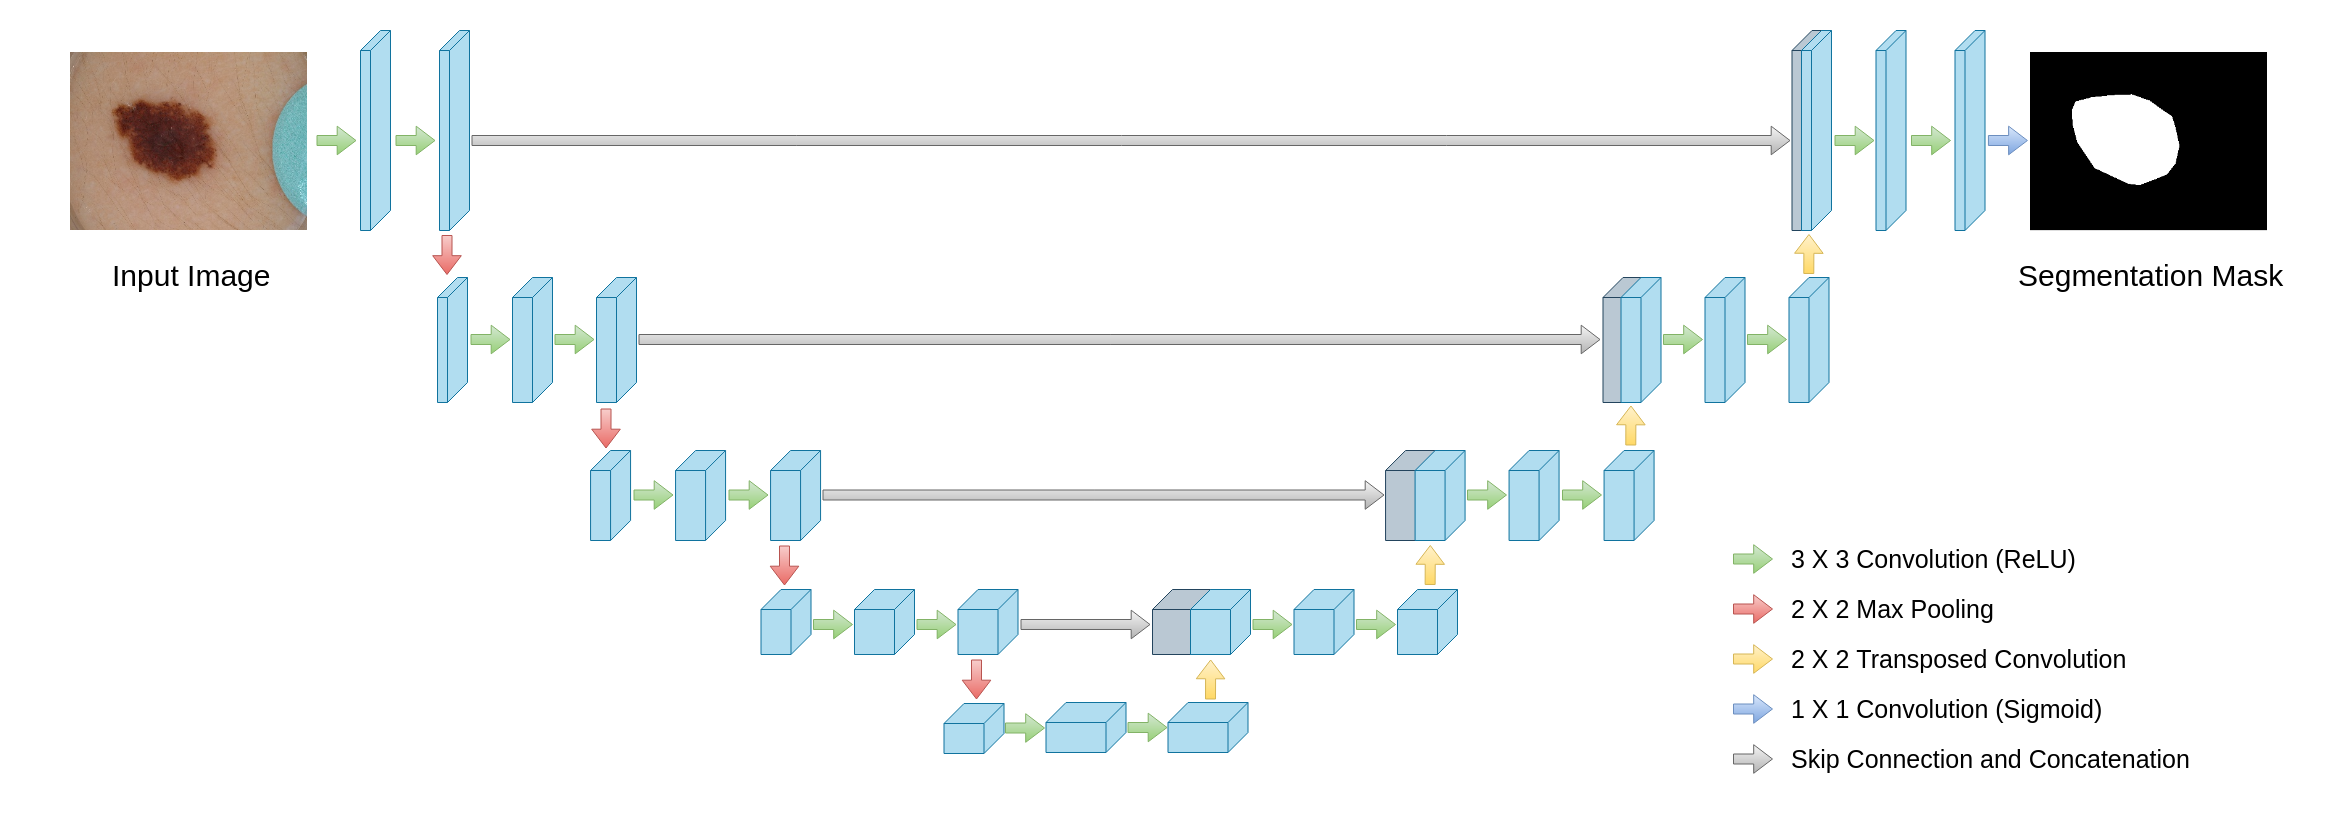

@article{ibtehaz2020multiresunet,
  title={MultiResUNet: Rethinking the U-Net architecture for multimodal biomedical image segmentation},
  author={Ibtehaz, Nabil and Rahman, M Sohel},
  journal={Neural Networks},
  volume={121},
  pages={74--87},
  year={2020},
  publisher={Elsevier}
}

I used MultiResUNet for the model. The MultiResUNet is an extension of the original U-Net architecture that uses multiple parallel pathways with different resolutions to capture features at multiple scales. The MultiResUNet is designed to improve the segmentation accuracy of U-Net by incorporating information from different levels of detail in the input image.

The architecture of MultiResUNet consists of an encoder-decoder network with skip connections. The encoder consists of several layers of convolutional and pooling operations that downsample the input image. The decoder consists of several layers of upsampling and convolutional operations that reconstruct the segmentation mask at the original resolution. Skip connections connect the corresponding encoder and decoder layers to preserve spatial information.

In the MultiResUNet architecture, each level of the encoder is connected to a corresponding level of a parallel pathway that uses a higher resolution input image. The idea behind this is that the parallel pathways can capture features at different levels of detail and combine them to improve segmentation accuracy. In addition, the MultiResUNet uses residual connections between the encoder and decoder to improve training stability and prevent the vanishing gradient problem.

The MultiResUNet has shown good performance on various medical image segmentation tasks, such as brain tumor segmentation and retinal vessel segmentation.

In [26]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')
    
    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

In [27]:
def saveModel(model):
    model_json = model.to_json()
    try:
        os.makedirs('models')
    except:
        pass
    fp = open('models/modelP.json','w')
    fp.write(model_json)
    model.save_weights('models/modelW.h5')

### Metrics

In [28]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

Binary crossentropy is used since our labels are 0 and 1 (foreground or background). Binary cross-entropy (BCE) is a common loss function used for binary semantic segmentation tasks.

# Binary Semantic Segmantation for Artifacts

In [30]:
model = MultiResUnet(height=512, width=512, n_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

In [ ]:
results = model.fit(train_dataset, epochs=100, verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps,
                    validation_data=val_dataset)

Epoch 1/100
26/26 [==============================] - 166s 3s/step - loss: 0.7063 - dice_coef: 0.1943 - jacard: 0.1096 - accuracy: 0.6308 - val_loss: 0.8170 - val_dice_coef: 0.1767 - val_jacard: 0.0975 - val_accuracy: 0.3213
Epoch 2/100
26/26 [==============================] - 42s 2s/step - loss: 0.6746 - dice_coef: 0.2036 - jacard: 0.1151 - accuracy: 0.7433 - val_loss: 8.7818 - val_dice_coef: 0.1896 - val_jacard: 0.1056 - val_accuracy: 0.2042
Epoch 3/100
26/26 [==============================] - 52s 2s/step - loss: 0.6630 - dice_coef: 0.2025 - jacard: 0.1148 - accuracy: 0.7374 - val_loss: 1.9884 - val_dice_coef: 0.1923 - val_jacard: 0.1073 - val_accuracy: 0.1176
Epoch 4/100
26/26 [==============================] - 55s 2s/step - loss: 0.6411 - dice_coef: 0.2206 - jacard: 0.1266 - accuracy: 0.7619 - val_loss: 47.4606 - val_dice_coef: 0.1915 - val_jacard: 0.1068 - val_accuracy: 0.1067
Epoch 5/100
26/26 [==============================] - 47s 2s/step - loss: 0.6312 - dice_coef: 0.2223 - jaca

<ipython-input-35-8d3a6ff771ae>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


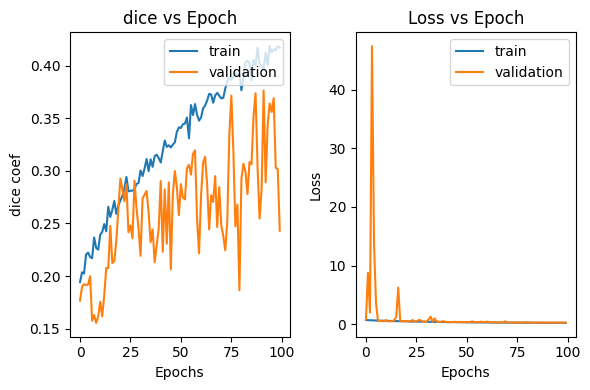

In [ ]:
plt.subplots(figsize=(6, 4))

plt.subplot(1,2,1)
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('dice vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('dice coef')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
K.clear_session()
raw_predictions = model.predict(test_dataset)

4/4 [==============================] - 25s 2s/step


In [ ]:
predictions = np.where(raw_predictions < 0.5, 0, 1)

<ipython-input-38-d1cf5ce36062>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 4, 2*idx+1)


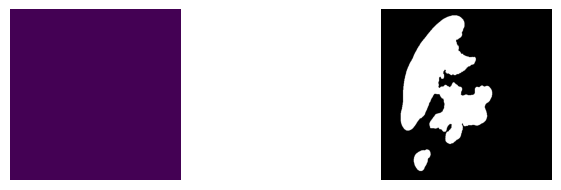

In [ ]:
plt.subplots(figsize=(15,15))
for idx, (image, label) in enumerate(test_dataset.unbatch()):
  plt.subplot(8, 4, 2*idx+1)
  plt.imshow(predictions[0])
  plt.axis('off')
  plt.subplot(8, 4, 2*idx+2)
  plt.imshow(label.numpy(), cmap='gray')
  plt.axis('off')
  break
plt.tight_layout()
plt.show()

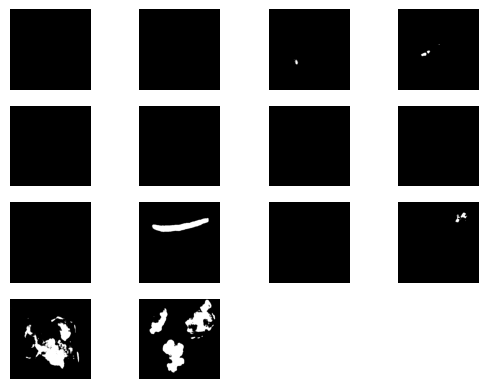

In [ ]:
for i in range(len(predictions)):
  plt.subplot(4, 4, i+1)
  plt.imshow(predictions[i], cmap='gray')
  plt.axis('off')

<ipython-input-65-adc738e55647>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


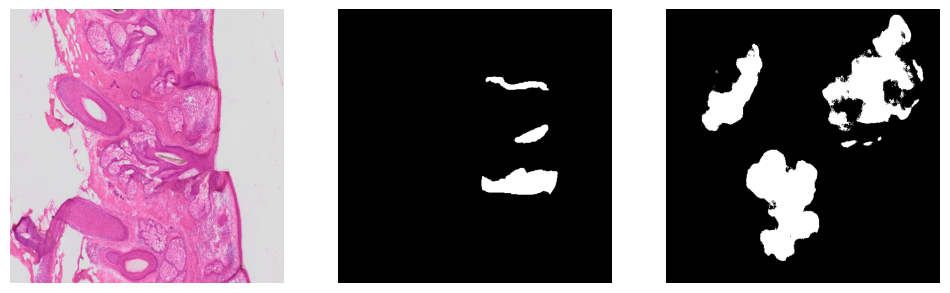

In [ ]:
for image, label in test_dataset.skip(3).take(1):
  plt.subplots(figsize=(12, 4))
  plt.subplot(1,3,1)
  plt.axis('off')
  plt.imshow(image.numpy()[1])
  plt.subplot(1,3,2)
  plt.axis('off')
  plt.imshow(label.numpy()[1], cmap='gray')
  plt.subplot(1,3,3)
  plt.axis('off')
  plt.imshow(predictions[13], cmap='gray')
  plt.show()

#  

# Binary Semantic Segmantation for Tumors

In [38]:
load_tumor_image = load_image_function(label_type='tumor')

In [39]:
folder_list = ['furkan (1-2)', 'furkan_(3to6)', 'furkan_7-14']

dataset_tumor = (
    get_dataset_from_folder_list(folder_list)
    .map(load_tumor_image)
    .filter(filter_zero_labels)
    .shuffle(buffer_size=buffer_size)
)

dataset_tumor_size = dataset_tumor.reduce(0, lambda x,_: x+1).numpy()

In [40]:
train_tumor_size = int(0.8 * dataset_tumor_size)
test_tumor_size = dataset_tumor_size - train_tumor_size

train_tumor_dataset = dataset.take(train_tumor_size)
test_tumor_dataset = dataset.skip(train_tumor_size).take(test_tumor_size)

In [ ]:
train_tumor_dataset_size = train_tumor_dataset.reduce(0, lambda x,_: x+1).numpy()
test_tumor_dataset_size = test_tumor_dataset.reduce(0, lambda x,_: x+1).numpy()

In [43]:
print(f"Train, test dataset batch count: {train_tumor_dataset_size + test_tumor_dataset_size}")
print(f"Base dataset batch count: {dataset_tumor_size}")

Train, test dataset batch count: 20
Base dataset batch count: 20


In [42]:
spe_tumor = int(train_tumor_dataset_size // batch_size)
print(f"Batch Size: {batch_size}\nSteps_per_epoch: {spe_tumor}")

Batch Size: 4
Steps_per_epoch: 4


In [44]:
# ///// Pipelining /////

# Only appllying augmentation on train dataset
train_tumor_dataset = (
    train_tumor_dataset
    .cache()
    .map(partial(process_data))
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=AUTOTUNE)
)

test_tumor_dataset = test_tumor_dataset.batch(batch_size)

<ipython-input-48-d9a958af935f>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(batch_size, 2, i+1)


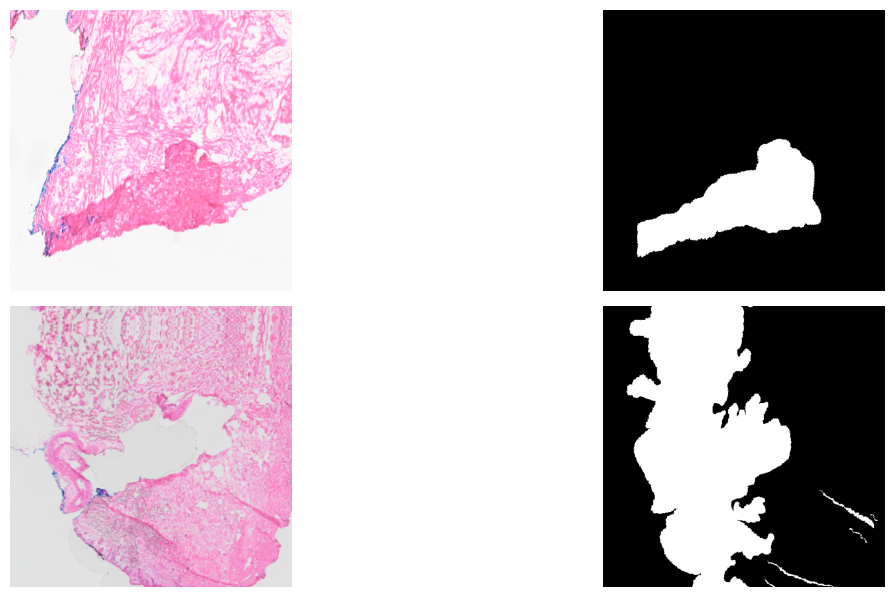

In [48]:
# Looking at the first batch
for image, label in train_tumor_dataset.take(1):
  plt.subplots(figsize=(12, 12))
  for i in range(0, batch_size, 2):
    plt.subplot(batch_size, 2, i+1)
    plt.imshow(image[i])
    plt.axis('off')
    plt.subplot(batch_size, 2, i+2)
    plt.imshow(label[i], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [49]:
model = MultiResUnet(height=512, width=512, n_channels=3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, 'accuracy'])

In [50]:
results = model.fit(train_tumor_dataset, epochs=5, verbose=1, steps_per_epoch=spe_tumor)

Epoch 1/5
4/4 [==============================] - 88s 1s/step - loss: 0.7559 - dice_coef: 0.1677 - jacard: 0.0922 - accuracy: 0.5415
Epoch 2/5
4/4 [==============================] - 6s 2s/step - loss: 0.6722 - dice_coef: 0.1928 - jacard: 0.1080 - accuracy: 0.6386
Epoch 3/5
4/4 [==============================] - 7s 2s/step - loss: 0.6517 - dice_coef: 0.2116 - jacard: 0.1204 - accuracy: 0.7309
Epoch 4/5
4/4 [==============================] - 8s 2s/step - loss: 0.6693 - dice_coef: 0.1923 - jacard: 0.1089 - accuracy: 0.6976
Epoch 5/5
4/4 [==============================] - 8s 2s/step - loss: 0.6819 - dice_coef: 0.1901 - jacard: 0.1061 - accuracy: 0.6911


In [51]:
K.clear_session()
raw_tumor_predictions = model.predict(test_dataset)

4/4 [==============================] - 26s 2s/step


In [52]:
tumor_predictions = np.where(raw_tumor_predictions < 0.5, 0, 1)

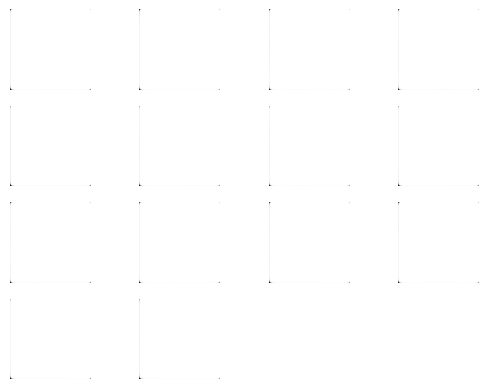

In [55]:
for i in range(len(raw_tumor_predictions)):
  plt.subplot(4, 4, i+1)
  plt.imshow(raw_tumor_predictions[i], cmap='gray')
  plt.axis('off')